In [1]:
import warnings  

warnings.filterwarnings("ignore")  #모든 경고 문구 출력하지 말고 무시해라!

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer   #Imputer는 누락된 값을 손쉽게 다루도록 해줌
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb #XGBoost Regression --> 예측력이 좋아서 많이 사용됨
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 데이터 로드

In [3]:
train = pd.read_csv('Data2/train.csv')
test = pd.read_csv('Data2/test.csv')

In [4]:
train.set_index('Id',inplace=True)
test.set_index('Id', inplace=True)
len_train = len(train)
len_test = len(test)

In [5]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,20,RL,NaN,21695,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,222000.000000
2,20,RL,NaN,10530,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,143250.000000
3,20,RL,88.0,12803,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,221000.000000
4,60,FV,114.0,8314,Pave,Pave,IR1,Lvl,AllPub,Corner,...,0,NaN,GdPrv,NaN,0,11,2006,WD,Normal,190269.599579
5,20,RL,78.0,10335,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,180000.000000


In [6]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1752,20,RL,78.0,10206,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
1753,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1754,60,RL,NaN,9930,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
1755,60,RL,92.0,9920,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
1756,50,RL,66.0,21780,Pave,NaN,Reg,Lvl,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [7]:
print(train.shape)  #데이터 크기 확인
print(test.shape)

(1751, 80)
(1168, 79)


#### 고려해야 할 변수가 너무 많음 
-> 독립변수와 종속 변수간 상관관계를 검토해보자

In [8]:
# corr()함수를 통한 df내 모든 변수의상관관계 그린 후 상관관계가 0.3이상인 변수만..
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>=0.3]
top_corr_features

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

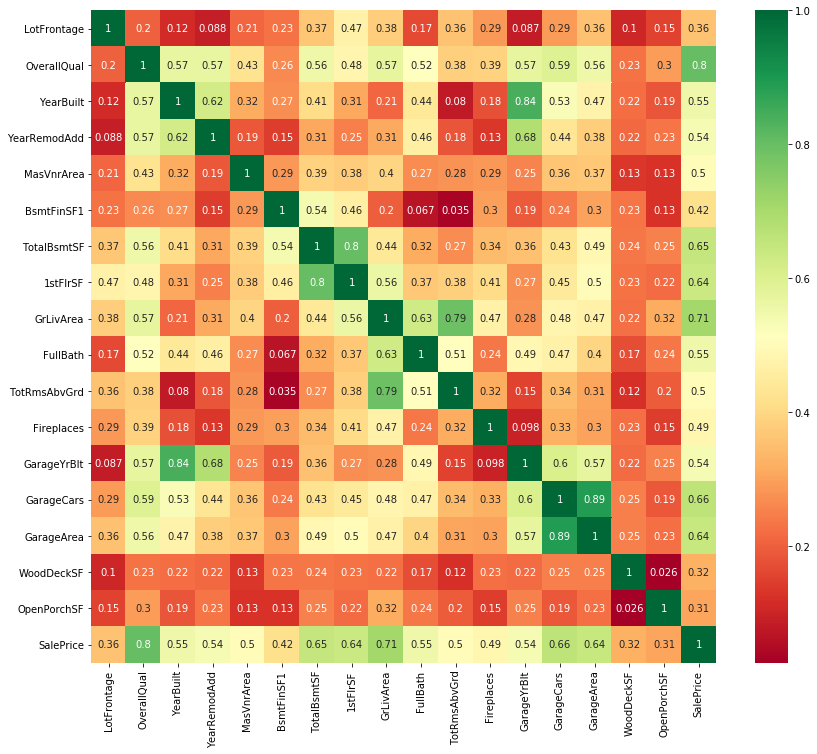

In [9]:
#위룰 토대로 heatmap 출력
plt.figure(figsize = (14,12))
sns.heatmap(train[top_corr_features].corr(), annot = True, cmap='RdYlGn')

In [10]:
#split y_label
train_y_label = train['SalePrice'] #target값(==집값) 분리
train.drop(['SalePrice'], axis = 1, inplace = True) #분리해줬으니 기존train에서는 제거

In [11]:
#train_y_label

### concat 훈련데이터&테스트데이터 ~~> 데이터 합치기
-> 왜? train셋과 test셋에 동일한 특성공학을 적용해 주기 위해서

In [12]:
house = pd.concat((train, test), axis = 0)
house_index = house.index

print('주택값 예측 데이터셋 길이(data point 갯수) :', len(house))
house.head()

주택값 예측 데이터셋 길이(data point 갯수) : 2919


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,20,RL,NaN,21695,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal
2,20,RL,NaN,10530,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
3,20,RL,88.0,12803,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,60,FV,114.0,8314,Pave,Pave,IR1,Lvl,AllPub,Corner,...,110,0,NaN,GdPrv,NaN,0,11,2006,WD,Normal
5,20,RL,78.0,10335,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal


### 결측치 처리
- Null값 비율 50퍼 이상-> 해당 특성 제거 (대부분이 null인 특성은 제거해줌) 

In [13]:
#house.info()

In [14]:
#house.isna().sum() / len(house)

In [15]:
check_null = house.isna().sum() / len(house)   #pd.isna() => 결측값은 True, 그 외는 False반환 ==> 결측치1개당 1씩 카운트 그리고 전체길이로 나눠서 비율(%) 알 수 있음

check_null[check_null >= 0.5]

Alley          0.932169
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
dtype: float64

In [16]:
remove_cols = check_null[check_null >= 0.5].keys() #Null값 비율 50퍼 이상인 컬럼명 담아서
house = house.drop(remove_cols, axis = 1) #해당 특성 제거

house.head() #특성 후 출력해보면?

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,20,RL,NaN,21695,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,44,0,182,0,0,0,12,2009,WD,Normal
2,20,RL,NaN,10530,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,312,40,0,0,0,0,3,2007,WD,Normal
3,20,RL,88.0,12803,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,9,2008,WD,Normal
4,60,FV,114.0,8314,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,382,0,0,110,0,0,11,2006,WD,Normal
5,20,RL,78.0,10335,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,96,180,0,0,0,0,7,2006,WD,Normal


### 수치형 데이터로 데이터형 변환

In [17]:
#house.info()

In [18]:
# 카테고리형과 수치형 분리
house_obj = house.select_dtypes(include='object')
house_num = house.select_dtypes(exclude='object')

In [19]:
print("카테고리형 컬럼 : \n", house_obj.columns)

카테고리형 컬럼 : 
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [20]:
print("수치형 컬럼 : \n", house_num.columns)

수치형 컬럼 : 
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


##### 카테고리형 컬럼 데이터에 one-hot-encoding 적용
- 문자를 숫자로 바꾸어 주는 방법 중 하나인 One Hot Encoding
- 가변수or더미변수(dummy variable)로 만들어줌.
- *이는 0과 1로 이루어진 열을 나타냄 (1:있다, 0:없다)

In [21]:
#더미지표를 가져올 house_obj
#첫 번째 수준을 제거(변수간 종속성 제거 피하기위해) drop_first=True(default:F)..->기준이 되는 범주를 제거해준다고 생각해봐
house_dummy = pd.get_dummies(house_obj, drop_first = True)
house_dummy.index = house_index  #하우스의인덱스와 동일하게 지정
house_dummy.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### null값 50프로 이하인 특성들 처리 (평균값으로 대체)

In [22]:
imputer = SimpleImputer(strategy='mean')   #'평균'값으로 대체하기 위해 strategy='mean'
#strategy에는 mean, median, most_frequent 존재한다!
imputer.fit(house_num) #Imputer객체의 fit()메서드를 사용하여 훈련데이터에 적용
house_num_ = imputer.transform(house_num)
#house_num_

In [23]:
house_num = pd.DataFrame(house_num_, columns=house_num.columns, index=house_index)
house_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,20.0,69.305795,21695.0,6.0,9.0,1988.0,2007.0,260.0,808.0,0.0,...,540.0,292.0,44.0,0.0,182.0,0.0,0.0,0.0,12.0,2009.0
2,20.0,69.305795,10530.0,6.0,5.0,1971.0,1971.0,0.0,282.0,35.0,...,576.0,0.0,312.0,40.0,0.0,0.0,0.0,0.0,3.0,2007.0
3,20.0,88.000000,12803.0,7.0,5.0,2002.0,2002.0,99.0,922.0,0.0,...,530.0,192.0,36.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,60.0,114.000000,8314.0,7.0,5.0,1997.0,1998.0,0.0,0.0,0.0,...,434.0,0.0,382.0,0.0,0.0,110.0,0.0,0.0,11.0,2006.0
5,20.0,78.000000,10335.0,5.0,6.0,1968.0,1993.0,0.0,570.0,0.0,...,440.0,0.0,96.0,180.0,0.0,0.0,0.0,0.0,7.0,2006.0


### 수치형데이터와 카테고리 데이터 merge

In [24]:
house = pd.merge(house_dummy, house_num, left_index = True, right_index=True)
house.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,0,0,...,540.0,292.0,44.0,0.0,182.0,0.0,0.0,0.0,12.0,2009.0
2,0,0,1,0,1,0,0,0,0,0,...,576.0,0.0,312.0,40.0,0.0,0.0,0.0,0.0,3.0,2007.0
3,0,0,1,0,1,0,0,0,0,0,...,530.0,192.0,36.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,1,0,0,0,1,0,0,0,0,0,...,434.0,0.0,382.0,0.0,0.0,110.0,0.0,0.0,11.0,2006.0
5,0,0,1,0,1,0,0,0,0,0,...,440.0,0.0,96.0,180.0,0.0,0.0,0.0,0.0,7.0,2006.0


### split

In [25]:
train = house[:len_train]
test  = house[len_train:]

train['SalePrice'] = train_y_label

print("훈련셋 길이 :", len(train))
print("테스트셋 길이 :", len(test))

훈련셋 길이 : 1751
테스트셋 길이 : 1168


In [26]:
X_train = train.drop(['SalePrice'], axis = 1)
y_train = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    shuffle=True)

In [27]:
print("X_train :", len(X_train))
print("X_test :", len(X_test))
print("y_train :", len(y_train))
print("y_test :", len(y_test))

X_train : 1400
X_test : 351
y_train : 1400
y_test : 351


### training

In [32]:
param = {
    'max_depth':[2,3,4],
    'n_estimators': range(550,700,50),
    'colsample_bytree': [0,5,0,7,1],
    'colsample_bylevel': [0,5,0,7,1]
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5,
                scoring='neg_mean_squared_error',
                          n_jobs=-1)
grid_search.fit(X_train,y_train)
print("최적 매개변수 :\n {}".format(grid_search.best_params_))
print("최고 성능 모델 :\n {}".format(grid_search.best_estimator_))

[14:03:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최적 매개변수 :
 {'colsample_bylevel': 1, 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 600}
최고 성능 모델 :
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


### 예측&점수

In [35]:
pred_train = grid_search.predict(X_train)
pred_test = grid_search.predict(X_test)

print("train MAE score :", mean_absolute_error(y_train, pred_train))
print("test MAE score :", mean_absolute_error(y_test, pred_test))

train MAE score : 3768.0273832075577
test MAE score : 11347.559573109671


<function matplotlib.pyplot.legend(*args, **kwargs)>

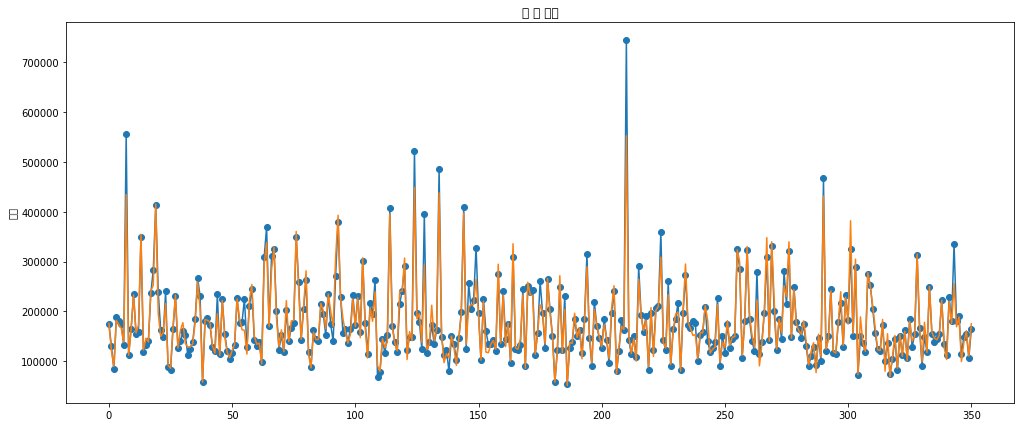

In [36]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test, 'o-', label='Validation Actual')
plt.plot(range(0, len(pred_test)), pred_test, '-', label='Validation Predict')
plt.title('집 값 예상')
plt.ylabel('가격')
plt.legend

In [37]:
test_y_pred = grid_search.predict(X_test)

In [38]:
id_pred = pd.DataFrame()
id_pred['Id'] = test_id_idx
id_pred['SalesPrice'] = test_y_pred

NameError: name 'test_id_idx' is not defined